<a href="https://colab.research.google.com/github/SomTheSheep/Unsloth/blob/Error/nb/Qwen2.5_VL_(7B)-Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

Unsloth now supports Text-to-Speech (TTS) models. Read our [guide here](https://docs.unsloth.ai/basics/text-to-speech-tts-fine-tuning).

Read our **[Gemma 3N Guide](https://docs.unsloth.ai/basics/gemma-3n-how-to-run-and-fine-tune)** and check out our new **[Dynamic 2.0](https://docs.unsloth.ai/basics/unsloth-dynamic-2.0-ggufs)** quants which outperforms other quantization methods!

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [12]:
from unsloth import FastLanguageModel  # Changed from FastVisionModel
import torch

# 4bit pre quantized text models
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-Instruct-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3-medium-4k-instruct-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",  # Changed to text model
    max_seq_length = 4096,  # Added sequence length for text
    dtype = None,
    load_in_4bit = True,
)

==((====))==  Unsloth 2025.7.8: Fast Llama patching. Transformers: 4.53.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

In [13]:
import os
import json
from transformers import TextStreamer


Expected folder structure
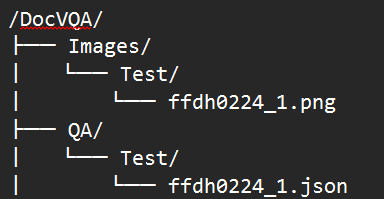

In [14]:
root_dir = "/DocVQA"
ocr_dir = os.path.join(root_dir, "OCR", "Test")  # Changed to OCR directory
qa_dir = os.path.join(root_dir, "QA", "Test")

# Output JSON file for results
output_path = "/content/prompt_outputs_ocr.json"

In [15]:
# Replace with your model and tokenizer initialization
# Assumes `model` and `tokenizer` are already loaded elsewhere (or load them here)
FastLanguageModel.for_inference(model)  # Changed from FastVisionModel
text_streamer = TextStreamer(tokenizer, skip_prompt=True)

def extract_text_from_ocr(ocr_data):
    """Extract all text from OCR JSON data."""
    text_content = []

    if "recognitionResults" in ocr_data:
        for result in ocr_data["recognitionResults"]:
            if "lines" in result:
                for line in result["lines"]:
                    text_content.append(line["text"])

    return "\n".join(text_content)


In [22]:
# Collect all QA files
qa_files = sorted(os.listdir(qa_dir))

# Load or initialize output
if os.path.exists(output_path):
    with open(output_path, "r") as f:
        all_data = json.load(f)
else:
    all_data = []

# Iterate through each QA file
for qa_filename in qa_files:
    file_id = qa_filename.replace(".json", "")  # like "ffdh0224_1"
    qa_file_path = os.path.join(qa_dir, qa_filename)
    ocr_file_path = os.path.join(ocr_dir, f"{file_id}.json")  # Changed to OCR JSON file

    # Skip if OCR file not found
    if not os.path.exists(ocr_file_path):
        print(f"OCR file not found for {file_id}, skipping.")
        continue

    # Load OCR data
    with open(ocr_file_path, "r") as f:
        ocr_data = json.load(f)

    # Extract text from OCR data
    document_text = extract_text_from_ocr(ocr_data)

    # Load questions
    with open(qa_file_path, "r") as f:
        qa_items = json.load(f)

    # Ask each question about the document text
    for qa in qa_items:
        question = qa["question"]

        # Prepare prompt for text-based QA
        messages = [
            {"role": "system", "content": "You are a helpful assistant that answers questions about documents based on the provided text content."},
            {"role": "user", "content": f"Document text:\n{document_text}\n\nQuestion: {question}\n\nPlease answer the question based on the document text above."}
        ]

        # Apply chat template
        input_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(
            input_text,
            add_special_tokens=False,
            return_tensors="pt"
        )

        # Ensure tokenizer pad token is set
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        # Move inputs to the same device as model
        model_device = next(model.parameters()).device
        inputs = {k: v.to(model_device) for k, v in inputs.items()}

        # Debug: Print device info
        print(f"Model device: {model_device}")
        print(f"Input tensor device: {inputs['input_ids'].device}")

        # Generate response
        with torch.no_grad():
            output_ids = model.generate(
    input_ids=inputs['input_ids'],
    attention_mask=inputs.get('attention_mask', None),
    max_new_tokens=128,
    use_cache=True,
    temperature=1.5,
    pad_token_id=tokenizer.pad_token_id
)


        # Decode response
        decoded_output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        output_text = decoded_output.replace(input_text, "").strip()

        print(f"\n[Document: {file_id}]")
        print(f"Q: {question}")
        print(f"A: {output_text}")

        # Store result
        all_data.append({
            "Document": file_id,
            "question": question,
            "output": output_text
        })

# Save all results
with open(output_path, "w") as f:
    json.dump(all_data, f, indent=2)

print(f"\nProcessing complete. Results saved to {output_path}")

Model device: cpu
Input tensor device: cpu


ValueError: Pointer argument (at 0) cannot be accessed from Triton (cpu tensor?)

G W Sugar refers to Great Western Sugar Company, which was a sugar company based in Denver, Colorado. The company was known for producing sugar and other related products. The image shows a receipt from the Great Western Sugar Company, which indicates that the company was involved in the sugar trade and distribution.</s>


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_seq_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
6.068 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 51,521,536/7,000,000,000 (0.74% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.787200
2,3.326000
3,3.431700
4,2.313500
5,2.053400
6,2.038500
7,1.522700
8,1.004700
9,0.716800
10,0.744900


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

219.9988 seconds used for training.
3.67 minutes used for training.
Peak reserved memory = 6.484 GB.
Peak reserved memory for training = 0.416 GB.
Peak reserved memory % of max memory = 43.986 %.
Peak reserved memory for training % of max memory = 2.822 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

H ^ { \prime } = \beta N \int d \lambda \left\{ \frac { 1 } { 2 \beta ^ { 2 } \bar { N } ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \right\} .<|im_end|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

\frac { N } { M } \in \mathbf { Z } , \frac { P } { Q } \in \mathbf { Z } , P \in \mathbf { Z }<|im_end|>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "PUT_HERE")

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
